In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

NFF_PATH = '/home/wwj/Repo/playgrounds/NeuralForceField/'
ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, NFF_PATH)
sys.path.insert(0, ODE_PATH)
sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint
#from torchdiffeq import odeint
from torchmd.ode import ODE
from torchmd.hamiltoinians import PairPot, MLP, LennardJones, Buck, LennardJones69
from torchmd.observable import DiffRDF
from torchmd.utils import dump_mov
from nglview import show_ase, show_file, show_mdtraj

from nff.utils.scatter import compute_grad
from nff.nn.layers import GaussianSmearing
from ase import Atoms

_ColormakerRegistry()

Nose Hover chain (NHC) integrator to sample a harmonic oscillator with canonical ensemble. This notebook tries to produce the example shown in the originial NHC paper.

J. Chem. Phys. 97, 2635 (1992); https://doi.org/10.1063/1.463940

In [13]:
class NHODE(torch.nn.Module):

    def __init__(self, model, mass, target_momentum=4.0, num_chains=2, ttime = 10.0, dt= 0.005, device=0, dim=3):
        super().__init__()
        self.model = model  
        self.mass = torch.Tensor(mass).to(device)
        self.device = device 
        self.target_momentum = target_momentum
        self.ttime = ttime 
        self.N_dof = mass.shape[0] * dim
        self.target_ke = (0.5 * self.N_dof * self.target_momentum **2 )
        
        self.T = self.target_momentum **2
        self.num_chains = num_chains
#         self.Q = np.array([self.N_dof * self.T * (ttime * dt)**2,
#                    *[self.T * (self.ttime * dt)**2]*(num_chains-1)])
        self.Q = np.array([1,
                   *[1]*(num_chains-1)]) 
        self.Q = torch.Tensor(self.Q).to(device)
        self.dim = dim
        
    def forward(self, t, pq):
        # pq are the canonical momentum and position variables
        with torch.set_grad_enabled(True):
            pq.requires_grad = True            
            
            N = self.N_dof
            
            p = pq[:N]
            q = pq[N:2* N].reshape(-1, self.dim)
            
            sys_ke = 0.5 * (p.reshape(-1, self.dim).pow(2) \
                 / self.mass[:, None]).sum() 
            
            # definite all the virtual momentums 
            p_v = pq[-self.num_chains:]      
            u = self.model(q)
            
            dqdt = (p.reshape(-1, self.dim) / self.mass[:, None]).reshape(-1)
            dpdt = -compute_grad(inputs=q, output=u).reshape(-1) - p_v[0] * p / self.Q[0]
        
            dpvdt_0 = 2 * (sys_ke - self.T * self.N_dof * 0.5) - p_v[0] * p_v[1]/ self.Q[1]
            dpvdt_mid = (p_v[:-2].pow(2) / self.Q[:-2] - self.T) - p_v[2:]*p_v[1:-1]/ self.Q[2:]
            dpvdt_last = p_v[-2].pow(2) / self.Q[-2] - self.T
                
            #print("KE {} Target KE{} ".format( sys_ke.item(), self.target_ke)) 
            
        return torch.cat((dpdt, dqdt, dpvdt_0[None], dpvdt_mid, dpvdt_last[None]))
    
class Harmonic1D(torch.nn.Module):
    def __init__(self):
        super(Harmonic1D, self).__init__()

    def forward(self, x):
        return 0.5 * x ** 2

In [14]:
DEVICE = 1

num_chains = 2

harm1d = Harmonic1D()

f_x = NHODE(harm1d, 
            torch.Tensor([1.0]), 
            ttime=50.0, 
            num_chains=num_chains, 
            device=DEVICE,
            target_momentum=1.0,
            dim=1).to(DEVICE)

In [19]:
p_v = torch.Tensor([1.0] * num_chains)

# generate random velocity 
q = (torch.Tensor([1.]))
p = (torch.Tensor([0.]))#.to(DEVICE)
pq = torch.cat((p, q, p_v)).to(DEVICE)
pq.requires_grad= True

In [20]:
t = torch.Tensor([0.01 * i for i in range(100000)]).to(DEVICE)
x = odeint(f_x, pq, t, method='rk4')

/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/wwj/anaconda3/envs/nff/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


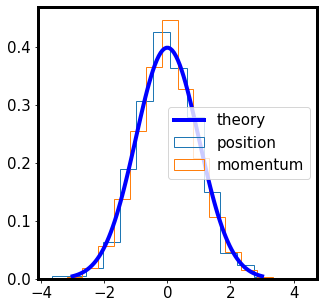

In [21]:
import scipy.stats as stats
import math
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=4, color='g')
matplotlib.rcParams['axes.linewidth'] = 3.0

mu = 0
variance = 1
sigma = math.sqrt(variance)
var = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

plt.figure(figsize=(5,5))
plt.plot(var, stats.norm.pdf(var, mu, sigma), label='theory', color='blue')

skip = 10
plt.hist(x[skip :, 1].detach().cpu().numpy(), normed=True, bins= 15, label='position', histtype='step')
plt.hist(x[skip :, 0].detach().cpu().numpy(), normed=True, bins= 15, label='momentum', histtype='step')

plt.legend()
plt.show()

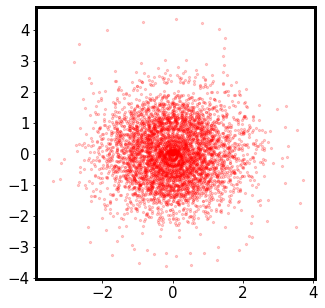

In [24]:
skip = 0
iterval = 20

plt.figure(figsize=(5,5))
plt.scatter(x[skip:, 0][::iterval ].detach().cpu().numpy(),
            x[skip:, 1][::iterval ].detach().cpu().numpy(), 
            s=5, alpha=0.2, c='red' )